In [1]:
import numpy as np
import time
from PIL import Image

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


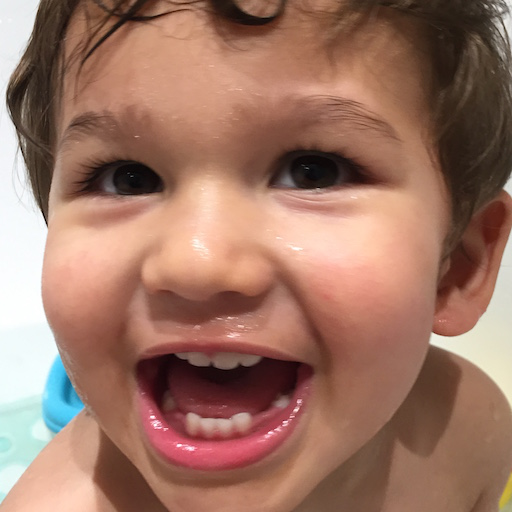

In [2]:
height = 512
width = 512

path = 'images/kid.png'
content = Image.open(path)
content = content.resize((height, width))
content

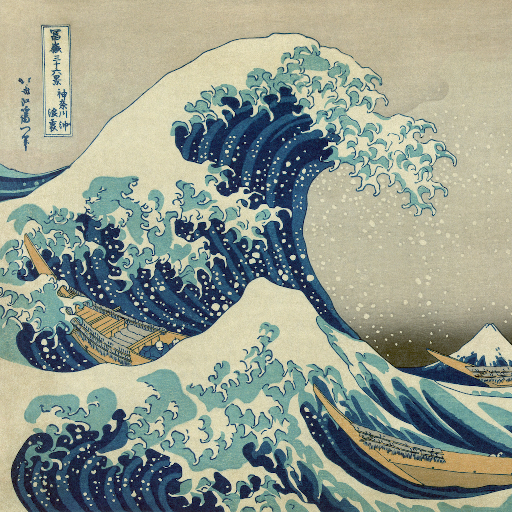

In [3]:
path = 'images/wave.png'
style = Image.open(path)
style = style.resize((height, width))
style

In [4]:
content_array = np.asarray(content, dtype='float32')
print(content_array.shape)
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)


style_array = np.asarray(style, dtype='float32')
print(style_array.shape)
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(512, 512, 3)
(1, 512, 512, 3)
(512, 512, 3)
(1, 512, 512, 3)


In [5]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:,:,:,::-1] # from RGB to BGR

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:,:,:,::-1] # from RGB to BGR

In [6]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
# combination_image = backend.placeholder?

In [7]:
combination_image = backend.placeholder((1, height, width, 3))
# one_more = backend.placeholder((1, height, width, 3))
# input_tensor = backend.concatenate?

In [10]:
# input_tensor = backend.concatenate

In [8]:
input_tensor = backend.concatenate([content_image, style_image, combination_image], axis=0)

In [12]:
# model = VGG16?

In [9]:
model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [10]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [11]:
content_weightage = 0.025
style_weightage = 5.0
total_variation_weightage = 1.0

In [12]:
loss = backend.variable(0.)

In [13]:
def content_loss(content, combination):
    return backend.sum(backend.square(content - combination))

layer_features = layers['block2_conv2']
print(layer_features.shape)
content_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

print(content_features.shape)
print(combination_features.shape)

loss += content_weightage * content_loss(content_features, combination_features)

(3, 256, 256, 128)
(256, 256, 128)
(256, 256, 128)


In [14]:
def gram_matrix(x):
    
    # print(x.shape)
    features = backend.permute_dimensions(x, (2,0,1))
    # print(features.shape)
    features = backend.batch_flatten(features)
    # print(features.shape)
    
    return backend.dot(features, backend.transpose(features))

In [15]:
def style_loss(style, combination):
    channels = 3
    size = height * width
    return backend.sum(backend.square(style - combination)) / (4.0 * (channels ** 2) * (size ** 2))

# feature_layers = [layer.name for layer in model.layers]
feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3',\
                 'block4_conv3', 'block5_conv3']
# feature_layers
for layer in feature_layers:
    layer_features = layers[layer]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_gram = gram_matrix(style_features)
    combination_gram = gram_matrix(combination_features)
    s_loss = style_loss(style_gram, combination_gram)
    loss += s_loss * (style_weightage / len(feature_layers))
    

In [97]:
# backend.batch_flatten?
# backend.permute_dimensions?

In [117]:
# backend.function?
# backend.reshape?

In [16]:
def total_variation_loss(combination_image):
    first = backend.square(combination_image[:, :height-1, :width-1, :] - combination_image[:, 1:, :width-1, :])
    second = backend.square(combination_image[:, :height-1, :width-1, :] - combination_image[:, :height-1, 1:, :])
    return backend.sum(backend.pow(first + second, 1.25))

loss += total_variation_loss(combination_image) * total_variation_weightage

In [30]:
fmin_l_bfgs_b?

In [24]:
backend.function?

In [ ]:
backend.gradients?

In [18]:
grads = backend.gradients(loss, combination_image)
# backend.is_keras_tensor(grads)

In [33]:
outputs = [loss]
outputs += grads
print(outputs)
f_outputs = backend.function([combination_image], outputs)

def loss_and_gradients(x):
    print(x.shape)
    x = x.reshape((1, height, width, 3))
    output_array = f_outputs([x])
    loss = output_array[0]
    grads = output_array[1].flatten().astype('float64')
    return loss, grads
    
class Evaluate(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None
    
    def loss(self, x):
        assert self.loss_value is None
        self.loss_value, self.grad_values = loss_and_gradients(x)
        return self.loss_value
        
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluate = Evaluate()

[<tf.Tensor 'add_7:0' shape=() dtype=float32>, <tf.Tensor 'gradients_1/AddN_15:0' shape=(1, 512, 512, 3) dtype=float32>]


Start of iteration: 0
(786432,)
(786432,)
(786432,)
(786432,)
(786432,)
(786432,)
(786432,)
current loss: 1789294804992.0
time taken: 319.1868212223053


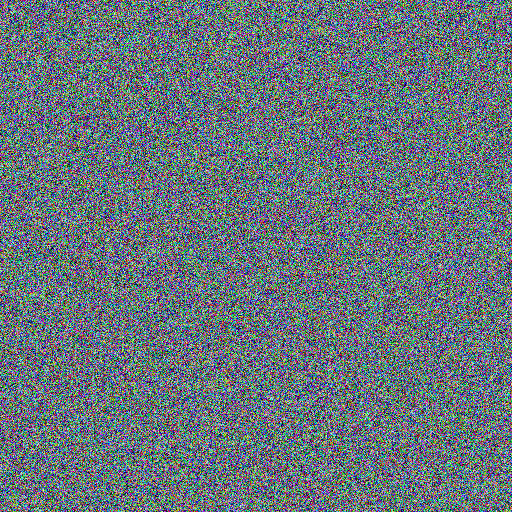

In [35]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128

iterations = 10

for i in range(iterations):
    print('Start of iteration: {}'.format(i))
    start_time = time.time()
    x, min_loss, info = fmin_l_bfgs_b(evaluate.loss, x.flatten(), evaluate.grads, maxfun=20)
    print('current loss: {}'.format(min_loss))
    print('time taken: {}'.format(time.time() - start_time))
    
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)